# **5. KNN**

Se selccionan las variables explicativas y la respuesta.

In [1]:

from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import math
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc, roc_auc_score, classification_report
)
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler



Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [3]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [5]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [7]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    """Evalúa un modelo y grafica sus métricas principales"""
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n🔹 {nombre_modelo}")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }

## 5. KNN sin usar tecnicas de optimizacion

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


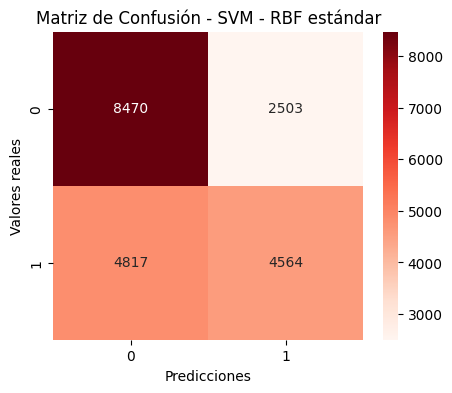


🔹 SVM - RBF estándar
Accuracy: 0.640 | Precision: 0.646 | Recall: 0.487 | F1: 0.555
AUC: 0.692
              precision    recall  f1-score   support

           0       0.64      0.77      0.70     10973
           1       0.65      0.49      0.55      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.63     20354



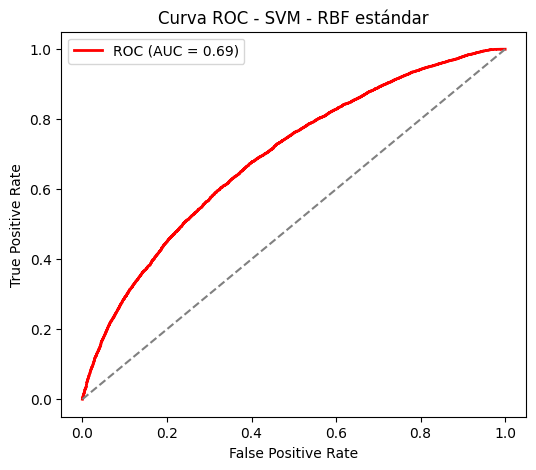

In [8]:
# 🔹 3.1 SVM estándar (kernel RBF)
start = time.time()
svm_rbf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(kernel="rbf", gamma="scale", C=1.0, probability=True))
])
svm_rbf.fit(X_train, y_train)
end = time.time()
metrics_rbf = evaluar_modelo(svm_rbf, X_test, y_test, "SVM - RBF estándar")
metrics_rbf["Tiempo (s)"] = round(end - start, 3)

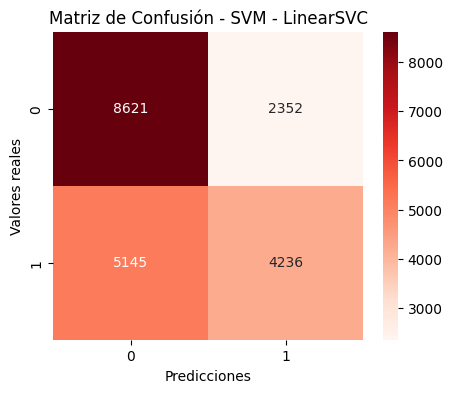


🔹 SVM - LinearSVC
Accuracy: 0.632 | Precision: 0.643 | Recall: 0.452 | F1: 0.531
              precision    recall  f1-score   support

           0       0.63      0.79      0.70     10973
           1       0.64      0.45      0.53      9381

    accuracy                           0.63     20354
   macro avg       0.63      0.62      0.61     20354
weighted avg       0.63      0.63      0.62     20354



In [9]:
# 🔹 3.2 SVM lineal optimizado (LinearSVC)
start = time.time()
svm_linear = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LinearSVC(C=1.0, max_iter=2000, dual=False))
])
svm_linear.fit(X_train, y_train)
end = time.time()
metrics_linear = evaluar_modelo(svm_linear, X_test, y_test, "SVM - LinearSVC")
metrics_linear["Tiempo (s)"] = round(end - start, 3)


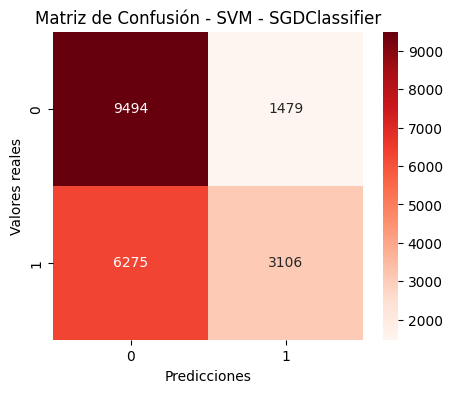


🔹 SVM - SGDClassifier
Accuracy: 0.619 | Precision: 0.677 | Recall: 0.331 | F1: 0.445
              precision    recall  f1-score   support

           0       0.60      0.87      0.71     10973
           1       0.68      0.33      0.44      9381

    accuracy                           0.62     20354
   macro avg       0.64      0.60      0.58     20354
weighted avg       0.64      0.62      0.59     20354



In [10]:
# 🔹 3.3 SVM aproximado con SGDClassifier (hinge loss)
start = time.time()
svm_sgd = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SGDClassifier(loss="hinge", alpha=0.0001, max_iter=1000, random_state=42))
])
svm_sgd.fit(X_train, y_train)
end = time.time()
metrics_sgd = evaluar_modelo(svm_sgd, X_test, y_test, "SVM - SGDClassifier")
metrics_sgd["Tiempo (s)"] = round(end - start, 3)

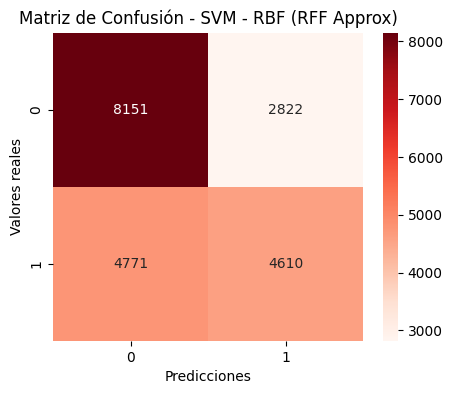


🔹 SVM - RBF (RFF Approx)
Accuracy: 0.627 | Precision: 0.620 | Recall: 0.491 | F1: 0.548
              precision    recall  f1-score   support

           0       0.63      0.74      0.68     10973
           1       0.62      0.49      0.55      9381

    accuracy                           0.63     20354
   macro avg       0.63      0.62      0.62     20354
weighted avg       0.63      0.63      0.62     20354



In [11]:
start = time.time()
svm_rff = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rff", RBFSampler(gamma=0.1, n_components=500, random_state=42)),
    ("classifier", LinearSVC(C=1.0, max_iter=2000, dual=False))
])
svm_rff.fit(X_train, y_train)
end = time.time()
metrics_rff = evaluar_modelo(svm_rff, X_test, y_test, "SVM - RBF (RFF Approx)")
metrics_rff["Tiempo (s)"] = round(end - start, 3)

In [12]:
resultados_svm = pd.DataFrame([
    metrics_rbf,
    metrics_linear,
    metrics_sgd,
    metrics_rff
])


🔍 Resultados comparativos - SVM optimizadas:

                   Modelo  Accuracy  Precision    Recall        F1       AUC  \
0      SVM - RBF estándar  0.640366   0.645819  0.486515  0.554961  0.691903   
1  SVM - RBF (RFF Approx)  0.626953   0.620291  0.491419  0.548385       NaN   
2         SVM - LinearSVC  0.631669   0.642987  0.451551  0.530528       NaN   
3     SVM - SGDClassifier  0.619043   0.677426  0.331095  0.444795       NaN   

   Tiempo (s)  
0     181.134  
1      12.530  
2       9.282  
3       2.406  


C:\Users\taran\AppData\Local\Temp\ipykernel_6108\2718448672.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Modelo", x="F1", data=tabla_resultados, palette="Reds_r")


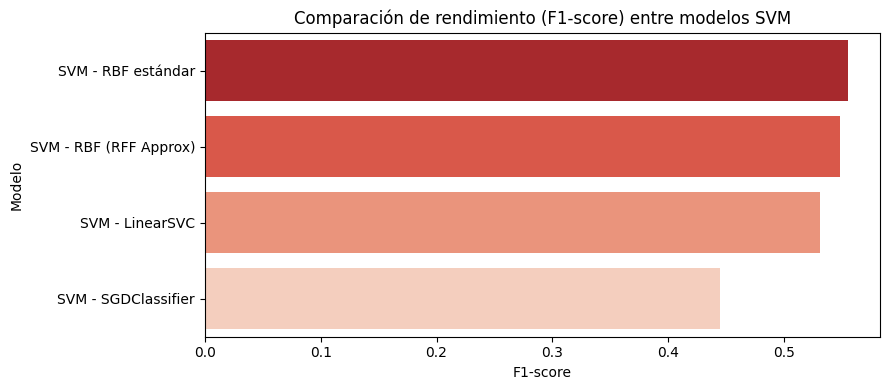

C:\Users\taran\AppData\Local\Temp\ipykernel_6108\2718448672.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Modelo", x="Tiempo (s)", data=tabla_resultados, palette="Reds_r")


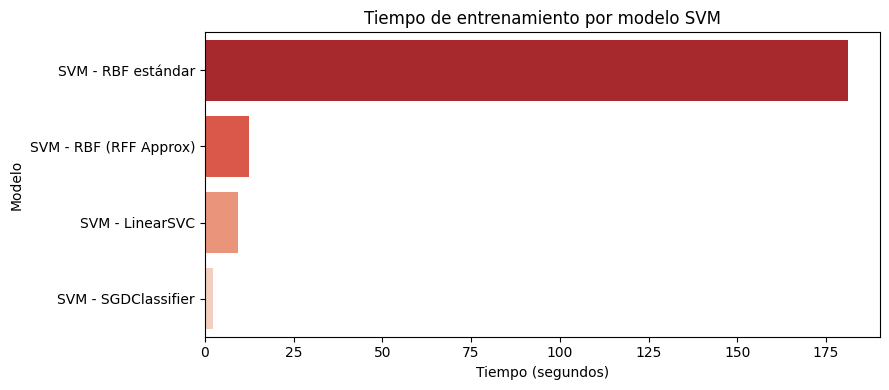

In [13]:
tabla_resultados = resultados_svm.sort_values("F1", ascending=False).reset_index(drop=True)
print("\n🔍 Resultados comparativos - SVM optimizadas:\n")
print(tabla_resultados)

# =====================================
# 5️⃣ Visualizaciones comparativas
# =====================================

plt.figure(figsize=(9, 4))
sns.barplot(y="Modelo", x="F1", data=tabla_resultados, palette="Reds_r")
plt.title("Comparación de rendimiento (F1-score) entre modelos SVM")
plt.xlabel("F1-score")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 4))
sns.barplot(y="Modelo", x="Tiempo (s)", data=tabla_resultados, palette="Reds_r")
plt.title("Tiempo de entrenamiento por modelo SVM")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Modelo")
plt.tight_layout()
plt.show()